<a href="https://colab.research.google.com/github/BrainConnection/Quantum_Algorithm/blob/main/1.%20TFIM%20VQE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setting

In [ ]:
!pip install qiskit
!pip install qiskit-ibm-runtime
!pip install qiskit[visualization]
!pip install qiskit-algorithms

!pip install scipy
!pip install matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 15.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.4/39.4 MB 39.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.5/107.5 kB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.8/315.8 kB 11.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.0/62.0 kB 6.0 MB/s eta 0:00:00


In [ ]:
from qiskit_ibm_runtime import QiskitRuntimeService, Session, Estimator, Options

# Save an IBM Quantum account and set it as your default account.
QiskitRuntimeService.save_account(channel="ibm_quantum",
                                  token="067e5c82606f0a1157dd554e2087d6b7a9b823dbaa4ad47b95c3337eab2e6cd9361719cc0470f4a98d1631b73b264a82577012a0b8ff32963d5964e6cc12c525",
                                  set_as_default=True,
                                  overwrite=True)

service = QiskitRuntimeService()
backend = service.get_backend("ibmq_qasm_simulator")
backend.name

# Hamiltonian Diagonalization

$$ H = -(1-g) Σ Z_j Z_{j+1} -g Σ X_j  $$

1D 5 Qubit System

In [ ]:
from qiskit.quantum_info import SparsePauliOp
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
def exact_eigen_energy_open(g):
  interation = -(1-g)
  bias = -g

  coeff_list = [interation for _ in range(5)] + [bias for _ in range(5)]
  operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "ZIIIZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX"]
  hamiltonian_list = []
  for i in range(10):
    hamiltonian_list.append((operator_list[i], coeff_list[i]))
  hamiltonian = SparsePauliOp.from_list(hamiltonian_list)
  hamiltonian_matrix = hamiltonian.to_matrix()

  eigenvalue, eigenvector = np.linalg.eig(hamiltonian_matrix)

  lowest_energy = np.min(eigenvalue)
  return np.real(lowest_energy)

In [ ]:
def exact_eigen_energy_closed(g):
  interation = -(1-g)
  bias = -g

  coeff_list = [interation for _ in range(4)] + [bias for _ in range(5)]
  operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX"]
  hamiltonian_list = []
  for i in range(9):
    hamiltonian_list.append((operator_list[i], coeff_list[i]))
  hamiltonian = SparsePauliOp.from_list(hamiltonian_list)
  hamiltonian_matrix = hamiltonian.to_matrix()

  eigenvalue, eigenvector = np.linalg.eig(hamiltonian_matrix)

  lowest_energy = np.min(eigenvalue)
  return np.real(lowest_energy)

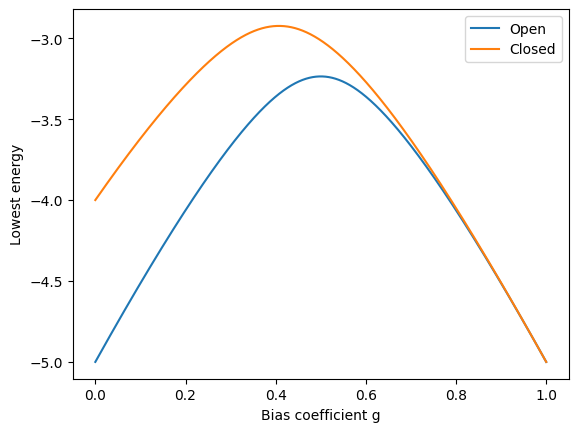

In [ ]:
g_list = np.array([0.0001*g for g in range(10001)])
open_energy_list = np.array([exact_eigen_energy_open(0.0001*g) for g in range(10001)])
closed_energy_list = np.array([exact_eigen_energy_closed(0.0001*g) for g in range(10001)])

plt.figure()
plt.plot(g_list, open_energy_list, label="Open")
plt.plot(g_list, closed_energy_list, label="Closed")
plt.xlabel("Bias coefficient g")
plt.ylabel("Lowest energy")
plt.legend()

In [ ]:
interation = 1
bias = -1

coeff_list = [interation for _ in range(5)] + [bias for _ in range(5)]
operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "ZIIIZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX"]
hamiltonian_list = []
for i in range(10):
  hamiltonian_list.append((operator_list[i], coeff_list[i]))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)
hamiltonian_matrix = hamiltonian.to_matrix()

eigenvalue, eigenvector = np.linalg.eig(hamiltonian_matrix)

lowest_energy = np.min(eigenvalue)

np.real(lowest_energy)

-6.155367074350501

# VQE in Exact Simulator (Method 1)

quantum_algorithms VQE object

In [ ]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import ParameterVector
import numpy as np

# Instantiate the system Hamiltonian
interation = 1
bias = -1

coeff_list = [interation for _ in range(5)] + [bias for _ in range(5)]
operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "ZIIIZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX"]
hamiltonian_list = []
for i in range(10):
    hamiltonian_list.append((operator_list[i], coeff_list[i]))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)

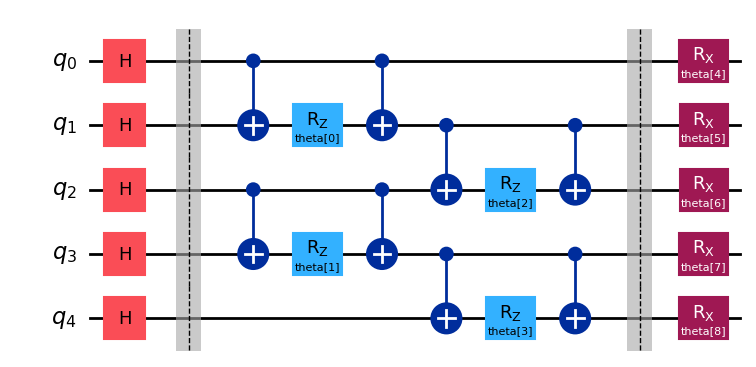

In [ ]:
ansatz = QuantumCircuit(5)
params = ParameterVector("theta", length=9)
it = iter(params)
ansatz.h(range(0,5))

ansatz.barrier()

ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.rz(next(it), 1)
ansatz.rz(next(it), 3)
ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.cx(1, 2)
ansatz.cx(3, 4)
ansatz.rz(next(it), 2)
ansatz.rz(next(it), 4)
ansatz.cx(1, 2)
ansatz.cx(3, 4)

ansatz.barrier()

ansatz.rx(next(it), 0)
ansatz.rx(next(it), 1)
ansatz.rx(next(it), 2)
ansatz.rx(next(it), 3)
ansatz.rx(next(it), 4)

ansatz.draw("mpl")

In [ ]:
from qiskit_algorithms.optimizers import CG
from qiskit_algorithms import VQE, SamplingVQE
from qiskit_algorithms.gradients import LinCombEstimatorGradient
from qiskit.primitives import Estimator

step_list = np.array([i for i in range(20)])
vqe_list = []

for max in range(20):

  # Conjugate Gradient algorithm
  optimizer = CG(maxiter=max)

  # Gradient callable
  estimator = Estimator()
  grad = LinCombEstimatorGradient(estimator)  # optional estimator gradient
  vqe = VQE(estimator=estimator, ansatz=ansatz, optimizer=optimizer, gradient=grad)

  result = vqe.compute_minimum_eigenvalue(hamiltonian)
  vqe_list.append(result.optimal_value)

vqe_list = np.array(vqe_list)

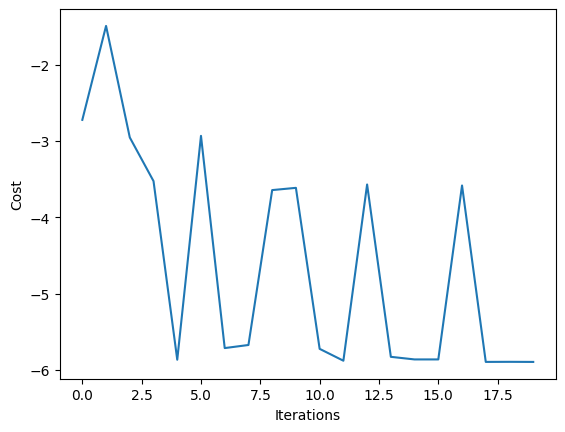

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
ax.plot(step_list, vqe_list)
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

# VQE in Exact Simulator (Method 2)

scipy minimize

## Function Definition

In [ ]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import ParameterVector
from qiskit.primitives import Estimator

import numpy as np
from scipy.optimize import minimize

In [ ]:
# Instantiate the system Hamiltonian

interation = 1
bias = -1
coeff_list = [interation for _ in range(5)] + [bias for _ in range(5)]
operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "ZIIIZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX"]
hamiltonian_list = []
for i in range(10):
    hamiltonian_list.append((operator_list[i], coeff_list[i]))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)


# Estimator

estimator = Estimator()

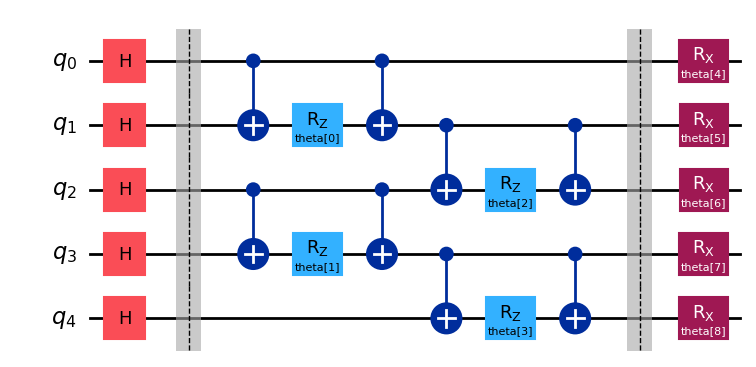

In [ ]:
# Ansatz

ansatz = QuantumCircuit(5)
params = ParameterVector("theta", length=9)
it = iter(params)
ansatz.h(range(0,5))

ansatz.barrier()

ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.rz(next(it), 1)
ansatz.rz(next(it), 3)
ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.cx(1, 2)
ansatz.cx(3, 4)
ansatz.rz(next(it), 2)
ansatz.rz(next(it), 4)
ansatz.cx(1, 2)
ansatz.cx(3, 4)

ansatz.barrier()

ansatz.rx(next(it), 0)
ansatz.rx(next(it), 1)
ansatz.rx(next(it), 2)
ansatz.rx(next(it), 3)
ansatz.rx(next(it), 4)

ansatz.draw("mpl")

In [ ]:
def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params).result()
    return cost.values[0]

In [ ]:
def build_callback(ansatz, hamiltonian, estimator, callback_dict):
  def callback(current_vector):
    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = current_vector
    current_cost = cost_func_vqe(current_vector, ansatz, hamiltonian, estimator)

    callback_dict["cost_history"].append(current_cost)

    print(
      "Iters. done: {} [Current cost: {}]".format(callback_dict["iters"], current_cost),
      end="\r",
      flush=True,
    )

  return callback

## Minimizing Method Trial

COBYLA, SLSQP, BFGS

In [ ]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

np.random.seed(0)
x0 = 2 * np.pi * np.random.random(9)

x0

array([3.44829694, 4.49366732, 3.78727399, 3.42360201, 2.66190161,
       4.0582724 , 2.74944154, 5.60317502, 6.0548717 ])

In [ ]:
callback = build_callback(ansatz, hamiltonian, estimator, callback_dict)
res = minimize(
  cost_func_vqe,
  x0,
  args=(ansatz, hamiltonian, estimator),
  method="cobyla",
  callback=callback,
)

In [ ]:
res

 message: Optimization terminated successfully.
 success: True
  status: 1
     fun: -3.6435201885196045
       x: [ 4.883e+00  3.738e+00  2.545e+00  4.883e+00  4.712e+00
            3.142e+00  4.712e+00  6.283e+00  7.854e+00]
    nfev: 230
   maxcv: 0.0

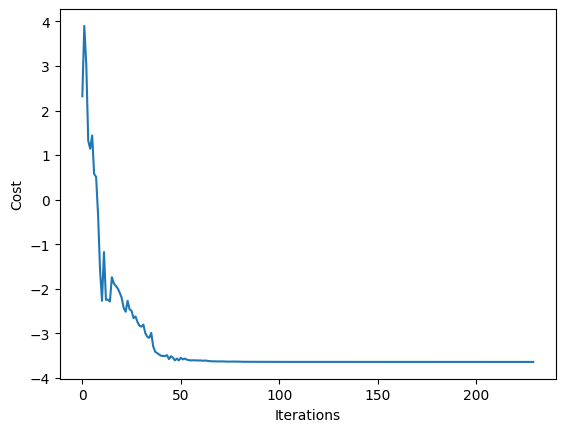

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

In [ ]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

np.random.seed(0)
x0 = 2 * np.pi * np.random.random(9)

x0

array([3.44829694, 4.49366732, 3.78727399, 3.42360201, 2.66190161,
       4.0582724 , 2.74944154, 5.60317502, 6.0548717 ])

In [ ]:
callback = build_callback(ansatz, hamiltonian, estimator, callback_dict)
res = minimize(
  cost_func_vqe,
  x0,
  args=(ansatz, hamiltonian, estimator),
  method="SLSQP",
  callback=callback,
)

In [ ]:
res

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -3.643519779244457
       x: [ 1.400e+00  2.544e+00  3.738e+00  4.884e+00  1.571e+00
            3.142e+00  1.571e+00  6.284e+00  7.855e+00]
     nit: 16
     jac: [-2.161e-05 -7.560e-04  2.649e-04  1.061e-04 -1.073e-04
            1.401e-04  2.520e-04  7.638e-05  2.156e-04]
    nfev: 161
    njev: 16

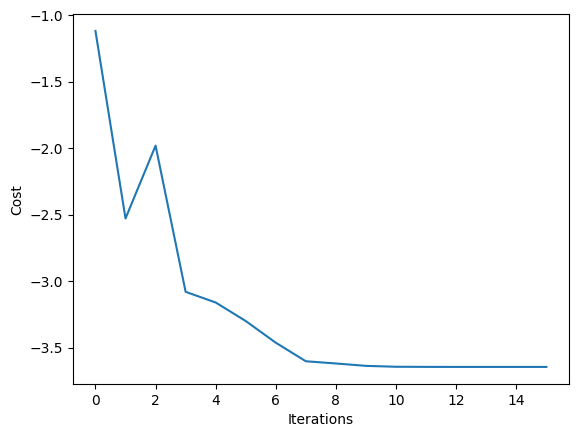

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

In [ ]:
callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
}

np.random.seed(0)
x0 = 2 * np.pi * np.random.random(9)

x0

array([3.44829694, 4.49366732, 3.78727399, 3.42360201, 2.66190161,
       4.0582724 , 2.74944154, 5.60317502, 6.0548717 ])

In [ ]:
callback = build_callback(ansatz, hamiltonian, estimator, callback_dict)
res = minimize(
  cost_func_vqe,
  x0,
  args=(ansatz, hamiltonian, estimator),
  method="BFGS",
  callback=callback,
)

In [ ]:
res

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: -3.643520200188793
        x: [ 1.400e+00  2.545e+00  3.738e+00  4.883e+00  1.571e+00
             3.142e+00  1.571e+00  6.283e+00  7.854e+00]
      nit: 19
      jac: [ 4.500e-06 -2.056e-06 -1.580e-06 -3.755e-06 -4.411e-06
             3.278e-06 -3.040e-06 -5.960e-08 -4.202e-06]
 hess_inv: [[ 1.169e+00 -2.590e-01 ...  1.009e-01  1.628e-01]
            [-2.590e-01  1.156e+00 ... -3.253e-02 -6.583e-02]
            ...
            [ 1.009e-01 -3.253e-02 ...  1.238e+00  9.664e-01]
            [ 1.628e-01 -6.583e-02 ...  9.664e-01  1.739e+00]]
     nfev: 200
     njev: 20

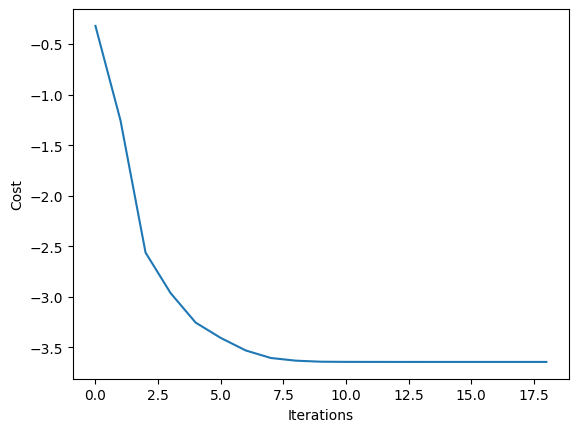

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()

## VQE Method 2

In [ ]:
ground_energy = 0
cost_history_list = []
callback_iter_list = []
local_minimum_list = []
for k in range(30):

  callback_dict = {
    "prev_vector": None,
    "iters": 0,
    "cost_history": [],
  }

  np.random.seed(k)
  x0 = 2 * np.pi * np.random.random(9)

  callback = build_callback(ansatz, hamiltonian, estimator, callback_dict)

  options = dict()
  options["maxiter"] = 50
  options["disp"] = True

  res = minimize(
    cost_func_vqe,
    x0,
    args=(ansatz, hamiltonian, estimator),
    method="BFGS",
    callback=callback,
    options=options
  )

  local_minimum_dict = callback_dict["cost_history"]
  callback_iter_list.append(callback_dict["iters"])
  cost_history_list.append(local_minimum_dict)
  local_minimum_list.append(local_minimum_dict[-1])
  local_minimum = local_minimum_dict[-1]

  print(local_minimum_dict[-1])
  print()
  print()

  if ground_energy > local_minimum:
    ground_energy = local_minimum

Optimization terminated successfully.
         Current function value: -3.643520
         Iterations: 19
         Function evaluations: 200
         Gradient evaluations: 20
-3.643520200188793


Optimization terminated successfully.
         Current function value: -5.897229
         Iterations: 28
         Function evaluations: 340
         Gradient evaluations: 34
-5.8972291332323294


Optimization terminated successfully.
         Current function value: -3.643520
         Iterations: 26
         Function evaluations: 350
         Gradient evaluations: 35
-3.6435202002409492


Optimization terminated successfully.
         Current function value: -3.643520
         Iterations: 20
         Function evaluations: 230
         Gradient evaluations: 23
-3.6435202001793026


Optimization terminated successfully.
         Current function value: -5.897229
         Iterations: 45
         Function evaluations: 570
         Gradient evaluations: 57
-5.8972291333277225


Optimization terminat

In [ ]:
ground_energy

-5.897229133328316

In [ ]:
local_minimum_list[0:10]

[-3.643520200188793,
 -5.8972291332323294,
 -3.6435202002409492,
 -3.6435202001793026,
 -5.8972291333277225,
 -5.897229133306107,
 -5.897229133309015,
 -3.643520200227034,
 -5.897229133301893,
 -5.8972291333272935]

In [ ]:
local_minimum_list[10:20]

[-5.897229133326771,
 -5.89722913323855,
 -3.64352020020158,
 -5.8972291333072935,
 -5.897229133285094,
 -5.897229133319499,
 -3.6435202002234366,
 -5.897229133260013,
 -5.8972291333047755,
 -5.897229133324491]

In [ ]:
local_minimum_list[20:30]

[-5.897229133326296,
 -5.8972291328193425,
 -3.643520200234897,
 -5.897229133309418,
 -5.897229133320247,
 -5.897229133328316,
 -3.6435202001111398,
 -3.6435202002395792,
 -5.897229133326571,
 -5.897229133317941]

In [ ]:
seed_list = [1,4,5,6,8,9,10,11,13,14,15,17,18,19,20,21,23,24,25,28]

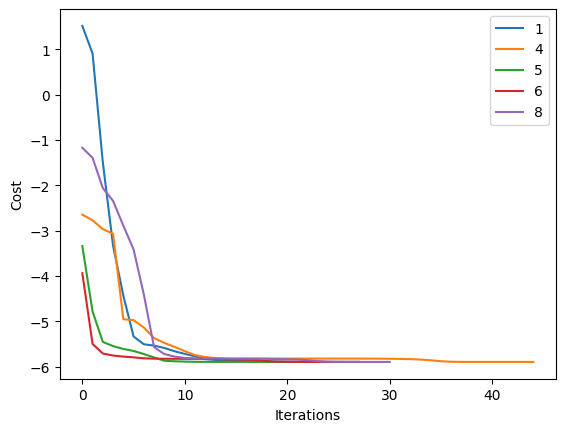

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(callback_iter_list[1]), cost_history_list[1], label="1")
ax.plot(range(callback_iter_list[4]), cost_history_list[4], label="4")
ax.plot(range(callback_iter_list[5]), cost_history_list[5], label="5")
ax.plot(range(callback_iter_list[6]), cost_history_list[6], label="6")
ax.plot(range(callback_iter_list[8]), cost_history_list[8], label="8")
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
ax.legend()
plt.draw()

# VQE in IBM Hardware

optimization_level = 3
resilence_level = 1
seed = 6

In [ ]:
from qiskit.circuit import QuantumCircuit, QuantumRegister, Parameter
from qiskit.quantum_info import SparsePauliOp
from qiskit.circuit import ParameterVector

from qiskit_ibm_runtime import QiskitRuntimeService, Estimator, Options
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

import numpy as np
from scipy.optimize import minimize

In [ ]:
# Instantiate the system Hamiltonian

interation = 1
bias = -1
coeff_list = [interation for _ in range(5)] + [bias for _ in range(5)]
operator_list = ["ZZIII", "IZZII", "IIZZI", "IIIZZ", "ZIIIZ", "XIIII", "IXIII", "IIXII", "IIIXI", "IIIIX"]
hamiltonian_list = []
for i in range(10):
    hamiltonian_list.append((operator_list[i], coeff_list[i]))
hamiltonian = SparsePauliOp.from_list(hamiltonian_list)

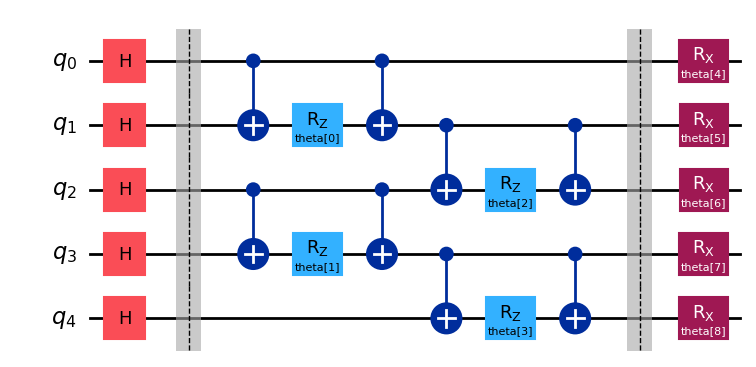

In [ ]:
# Ansatz

ansatz = QuantumCircuit(5)
params = ParameterVector("theta", length=9)
it = iter(params)
ansatz.h(range(0,5))

ansatz.barrier()

ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.rz(next(it), 1)
ansatz.rz(next(it), 3)
ansatz.cx(0, 1)
ansatz.cx(2, 3)
ansatz.cx(1, 2)
ansatz.cx(3, 4)
ansatz.rz(next(it), 2)
ansatz.rz(next(it), 4)
ansatz.cx(1, 2)
ansatz.cx(3, 4)

ansatz.barrier()

ansatz.rx(next(it), 0)
ansatz.rx(next(it), 1)
ansatz.rx(next(it), 2)
ansatz.rx(next(it), 3)
ansatz.rx(next(it), 4)

ansatz.draw("mpl")

In [ ]:
service = QiskitRuntimeService()

backend = service.least_busy(simulator=False, operational=True)
print(backend)

<IBMBackend('ibm_osaka')>


In [ ]:
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(ansatz)
isa_observable = hamiltonian.apply_layout(isa_circuit.layout)

options = Options()
options.optimization_level = 3
options.resilience_level = 1

estimator = Estimator(backend=backend, options=options)

In [ ]:
def cost_func_vqe(params, ansatz, hamiltonian, estimator):
    cost = estimator.run(ansatz, hamiltonian, parameter_values=params).result()
    return cost.values[0]

In [ ]:
def build_callback(ansatz, hamiltonian, estimator, callback_dict):
  def callback(current_vector):
    callback_dict["iters"] += 1
    callback_dict["prev_vector"] = current_vector
    current_cost = cost_func_vqe(current_vector, ansatz, hamiltonian, estimator)

    callback_dict["cost_history"].append(current_cost)

    print(
      "Iters. done: {} [Current cost: {}]".format(callback_dict["iters"], current_cost),
      end="\r",
      flush=True,
    )

  return callback

In [ ]:
callback_dict = {
  "prev_vector": None,
  "iters": 0,
  "cost_history": [],
}

np.random.seed(6)
x0 = 2 * np.pi * np.random.random(9)

callback = build_callback(isa_circuit, isa_observable, estimator, callback_dict)
options = dict()
options["maxiter"] = 400
options["disp"] = True

res = minimize(
  cost_func_vqe,
  x0,
  args=(isa_circuit, isa_observable, estimator),
  method="cobyla",
  callback=callback,
  options=options
)

ERROR:websocket:Connection to remote host was lost. - goodbye
ERROR:websocket:Connection to remote host was lost. - goodbye


KeyboardInterrupt: 

In [ ]:
res

In [ ]:
fig, ax = plt.subplots()
ax.plot(range(callback_dict["iters"]), callback_dict["cost_history"])
ax.set_xlabel("Iterations")
ax.set_ylabel("Cost")
plt.draw()